# One-Design-Variable Optimization

In [1]:
# Import settings and constants
import os   # module for interfacing with the underlying operating system
import sys  # module for interacting with the Python interpreter
parent_directory = os.path.join(os.path.dirname(os.getcwd()))
sys.path.append(parent_directory)
from settings import *

# Define name of directory where to save analyses and figures
FIGURES_DIRECTORY_PATH = os.getcwd()
DATA_DIRECTORY_PATH = r"C:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\19_One-variable_Optimization_of_the_CRM-like_Box_Beam"

## Development of the Model

Define constants of the model.

In [2]:
import numpy as np  # module for numerical operations

L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = 0.77e3   # [mm] box beam height
H_S = H/10   # [mm] stiffener height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates

Plot optimization history.

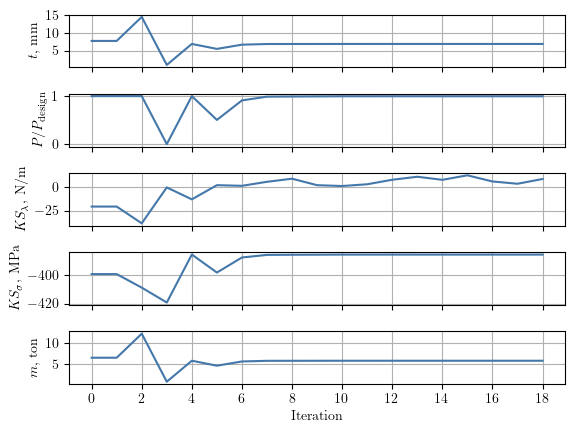

Design variables, constraints and objective at last iteration:
- nastran_solver.t: [6.85594425]
- nastran_solver.applied_load: [0.99737482]
- nastran_solver.ks_stability: [9.143357]
- nastran_solver.ks_stress: [-385.65618896]
- nastran_solver.mass: [5.80465725]


In [3]:
# Import helper module
main_directory = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(main_directory)
from resources import optimization_utils

recorder_filename = "sol_106_optimization3.sql"
recorder_filepath = os.path.join(DATA_DIRECTORY_PATH, recorder_filename)
fig, histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "OneDesignVariableOptHistory.pdf"), bbox_inches='tight', pad_inches=0)

Print mass reduction, initial thickness and final thickness.

In [4]:
feasible_design_index = np.where(histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_reduction = (histories['nastran_solver.mass'][feasible_design_index, 0]/histories['nastran_solver.mass'][0, 0] - 1)*100
initial_thickess = histories['nastran_solver.t'][0, 0]
final_thickness = histories['nastran_solver.t'][feasible_design_index, 0]
print(f"""
Initial thickness: {initial_thickess:.1f} mm
Final thickness: {final_thickness:1.1f} mm
Mass reduction: {mass_reduction:.1f} %""")


Initial thickness: 7.7 mm
Final thickness: 6.9 mm
Mass reduction: -10.9 %


Plot load-displacement diagrams.

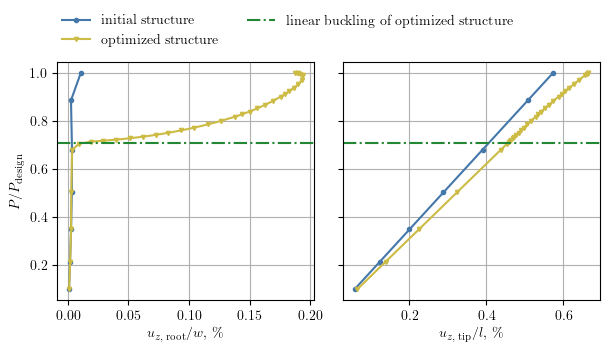

In [5]:
from resources import pynastran_utils, plot_utils
from pyNastran.op2.op2 import read_op2

# Design load is equal to linear buckling load of initial structure under distributed non-follower forces
design_load = 12517.  # [N]

# Make list with root and tip node IDs
plot_node_ids = [455, 14391]

# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_optimization_start",
                   "optimized structure": "sol_106_optimization3_feasible"}

# Create one figure with two subplots side by side
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*.5))
stable_lines = []

# Read eigenvalues, load and displacement histories and plot load-displacement diagrams
eigenvalues_dict = {}
sol_106_op2_dict = {}
nondimensional_loads_dict = {}
reference_lengths = [W, L]  # reference lengths for nondimensionalization of displacements
for i, (key, input_name) in enumerate(input_name_dict.items()):

    # Read eigenvalues
    f06_path = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
    eigenvalues_dict[key] =pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

    # Read load and displacement histories
    sol_106_op2_dict[key] = read_op2(os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
    _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2_dict[key], node_ids=plot_node_ids)
    nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
        
    # Plot load vs displacement for each node
    for j, node_id in enumerate(plot_node_ids):
        plot_utils.plot_2d_load_displacements_stability(
            axes[j],
            displacements[node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[j]*100,
            nondimensional_loads_dict[key],
            eigenvalues_dict[key],
            MARKERS[i], COLORS[i])
    
    # Create proxy artists for stable segments
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[i], color=COLORS[i], label=key))

# Plot linear buckling load line for optimized structure
sol_105_op2 = read_op2(os.path.join(DATA_DIRECTORY_PATH, "sol_105_optimization3_feasible.op2"), load_geometry=True, debug=None)
linear_buckling_load = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
for ax in axes:
    ax.axhline(y=linear_buckling_load, color=GLASS_CEILING_COLOR, linestyle='-.')

# Create proxy artists for unstable segments
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Make legend
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.25), frameon=False)  # add legend after tight_layout

# Show and save plot
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "OneDesignVariableLoadDisplacement.pdf"), bbox_inches='tight', pad_inches=0)

Plot deformation at design load of initial structure vs optimized structure.

Deformation of initial structure


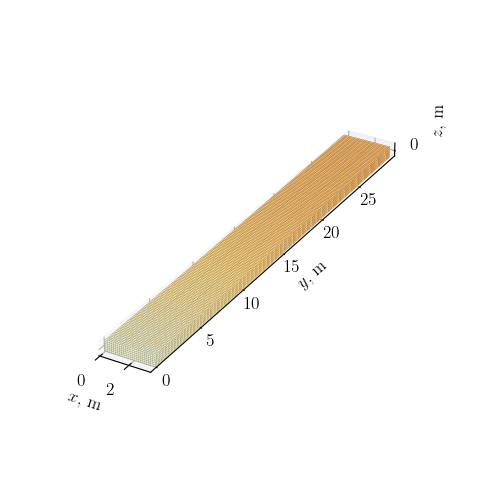

Deformation of optimized structure


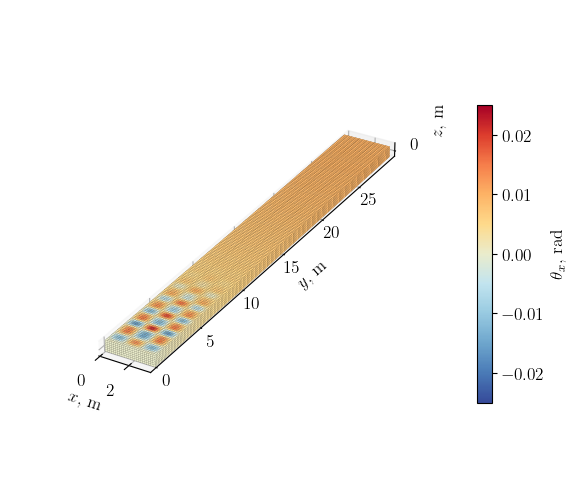

In [6]:
# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=25)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards
        
# Increase font size because figures will be side by side
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8})

# Plot deformation of initial structure
key = "initial structure"
print(f"Deformation of {key}")
clim = [-.025, .025]
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
bbox_no_colorbar = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"one_design_variable_{key.replace(' ', '_')}_deformation.pdf"),
            bbox_inches=bbox_no_colorbar, pad_inches=0)

# Plot deformation of nonlinearly optimized structure
key = "optimized structure"
print(f"Deformation of {key}")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, displacement_component='rx', colormap='sunset',
    length_unit='m', unit_scale_factor=1e-3, clim=clim)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
bbox_colorbar = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"one_design_variable_{key.replace(' ', '_')}_deformation.pdf"),
            bbox_inches=bbox_colorbar, pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})